# Лабораторная работа 5. 
Рассматривается задача бинарной классификации. Пусть заданы два
класса, распределение которых является многомерным нормальным ($\mu^+ \in R^2 -$ параметр положительного класса (+1), $\mu^- -$ отрицательного (-1), $\Sigma \in R^{2\times 2} - $общая для классов ковариационная матрица).

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Задача 1.
Подобрать параметры распределений таким образом, чтобы классы
немного пересекались (нельзя было разделить их линейной функцией).
## Задача 2. 
Сгенерировать по N = 30 объектов каждого класса. Разделить данные
каждого класса на 3 равные по объему выборки (тренировочную,
валидационную и тестовую).

In [25]:
mu_plus = np.array([1, 1])
mu_minus = np.array([3, 3])
cov_matrix = np.array([[1, 0.2], [0.2, 1]])

np.random.seed(42)

data_plus = np.random.multivariate_normal(mu_plus, cov_matrix, 30)
data_minus = np.random.multivariate_normal(mu_minus, cov_matrix, 30)
y = np.array([1]*30)

df = pd.DataFrame(data=np.concatenate((data_plus, data_minus), axis=0), columns=['feature_1', 'feature_2'])
df['target'] = np.concatenate((y, np.array([0]*30)), axis=0)

df = df.sample(frac=1).reset_index(drop=True)

df.head(7)

,feature_1,feature_2,target
0,2.083012,2.498853,0
1,1.137483,1.911200,1
2,1.395455,4.511237,0
3,-0.708621,0.262115,1
4,2.312179,3.537429,0
5,2.847586,2.753419,0
6,0.319603,0.536369,1


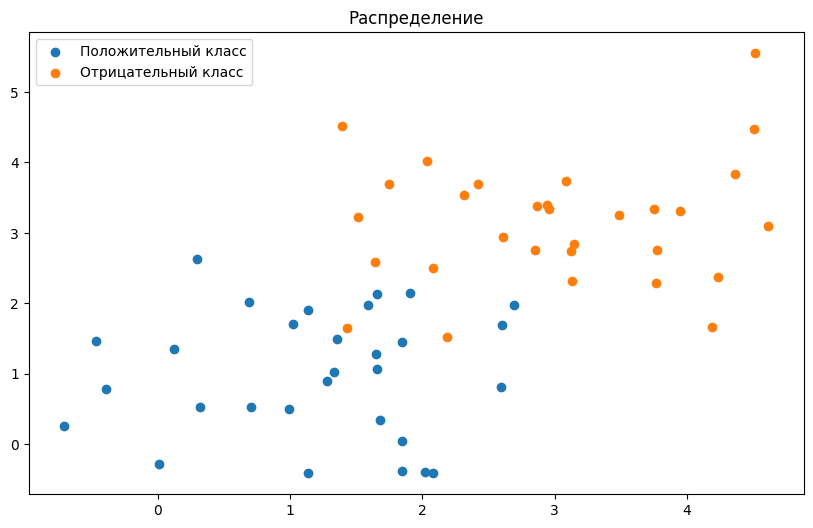

In [26]:
plt.figure(figsize=(10,6))

plt.title('Распределение')

plt.scatter(data_plus[:, 0], data_plus[:, 1], label='Положительный класс')
plt.scatter(data_minus[:, 0], data_minus[:, 1], label='Отрицательный класс')
plt.legend()
plt.show()

In [27]:
X, y = df.drop(columns='target'), df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/2, random_state=42)

In [28]:
print(len(X_train), len(X_test), len(X_val))

20 20 20


## Задача 3.
Реализовать и обучить модель логистической регрессии (логику
написать самим). Построить на графике полученную разделяющую
поверхность. Для нескольких объектов из обоих классов вывести оценки
вероятностей их распределения по классам.

In [29]:
class MyLogisticRegression:
    X = []
    y = []
    weights = []
    bias = []

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def __init__(self):
        self.X = []
        self.y = []
        self.weights = None
        self.bias = None

    def fit(self, X, y, alpha=0.03, num_iterations=1000):
        weights = np.zeros(X.shape[1] + 1)
        bias = np.ones(X.shape[0])
        X = np.insert(X, 2, bias, axis=1)
        
        for _ in range(num_iterations):
            x = np.dot(X, weights)
            h = self.sigmoid(x)
            grad = 2  / y.size * np.dot(X.T, (h - y))
            weights -= alpha * grad

        self.X = X
        self.y = y 
        self.weights = weights
        self.bias = bias

    def predict_probabilities(self, X):
        return self.sigmoid(np.dot(np.insert(X, 2, self.bias, axis=1), self.weights))

    def predict(self, X):
        probability = self.predict_probabilities(X)
        y_pred = (probability >= 0.5).astype(int)

        return y_pred
    
    def plot(self):
        plt.figure(figsize=(15, 6))
        plt.title('Разделяющая плокскость')

        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y)

        x = np.sort(self.X)
        y = -(self.weights[0] * x + self.weights[2]) / self.weights[1]

        plt.plot(x, y, color='red')
        plt.title('Logistic Regression Decision Boundary')
        plt.show()
    

In [30]:
model = MyLogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [31]:
print('MSE для моей логистической регрессии: ', mean_squared_error(y_test, y_pred))
print('MSE для встроенной логистической регрессии: ', mean_squared_error(y_test, LogisticRegression().fit(X_train, y_train).predict(X_test)))
print('MSE между двумя версиями: ', mean_squared_error(y_pred, LogisticRegression().fit(X_train, y_train).predict(X_test)))

MSE для моей логистической регрессии:  0.05
MSE для встроенной логистической регрессии:  0.05
MSE между двумя версиями:  0.0


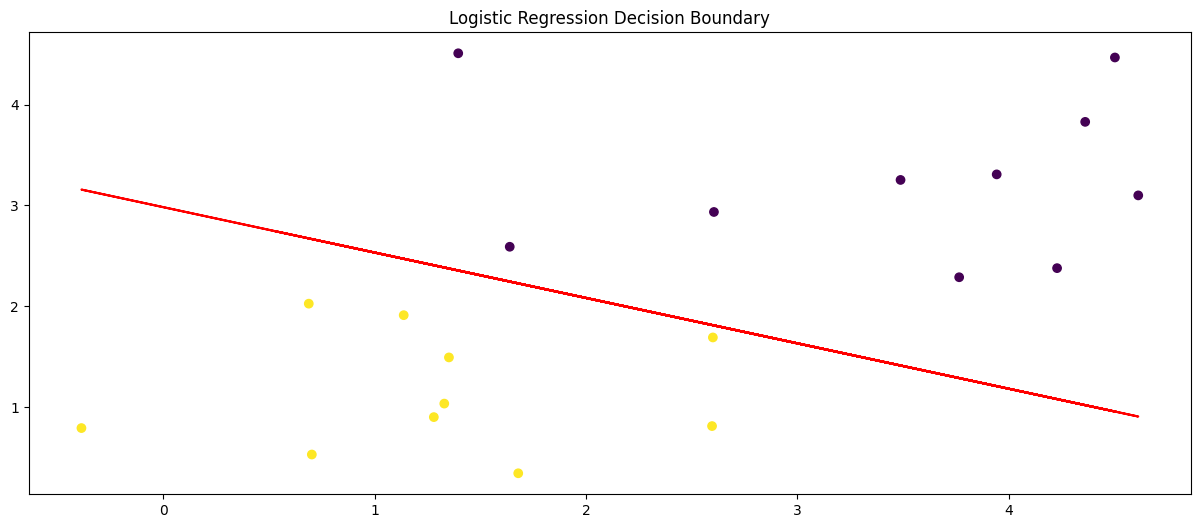

In [32]:
model.plot()

In [33]:
df_X = X_test.copy()
df_X['target'] = y_test
df_X['probability'] = model.predict_probabilities(X_test)

df_X.head(7)

,feature_1,feature_2,target,probability
0,2.083012,2.498853,0,0.338409
5,2.847586,2.753419,0,0.174371
36,4.185971,1.671873,0,0.299782
45,2.869387,3.380476,0,0.076182
13,1.653944,2.129168,1,0.540151
54,3.772870,2.758061,0,0.101798
33,2.022642,-0.397488,1,0.974583


## Задача 4.
Определить оптимальный порог $t$, при котором на валидационной
выборке определяются не менее $60%$ от поступающих положительных
объектов:

$$\hat{p}(y = +1|x) ≡ a(x) > t.$$

In [34]:
p_hat = model.predict_probabilities(X_val)

fpr, tpr, thresholds = roc_curve(y_val, p_hat)
auc = roc_auc_score(y_val, p_hat)

optimal_threshold = thresholds[np.argmax(tpr >= 0.6)]

print("Оптимальный порог:", optimal_threshold)

Оптимальный порог: 0.7368536403383442


## Задача 5. 
На тестовой выборке оценить качество полученного алгоритма,
рассчитав метрики (расчет метрик реализовать самим):

5.1. Accuracy;

5.2. Матрица ошибок;

5.3. Precision, Recall;

5.4. ROC – кривая, ROC-AUC.

In [35]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1)) 
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def roc_auc(y_true, y_score):
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = y_true[sorted_indices]
    tpr = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    fpr = np.cumsum(1 - y_true_sorted) / np.sum(1 - y_true_sorted)
    roc_auc = np.sum((tpr[1:] + tpr[:-1]) * (fpr[:-1] - fpr[1:]) / 2)
    return roc_auc, fpr, tpr

In [36]:
print('Accuracy: ', accuracy(y_test, y_pred))
print('\nPrecision: ', precision(y_test, y_pred))
print('\nRecall: ', recall(y_test, y_pred))
print('\nМатрица ошибок:\n', confusion_matrix(y_test, y_pred))

roc, fpr, tpr = roc_auc(y_test.to_numpy(), y_pred)
print('\nROC-AUC: ', roc)

Accuracy:  0.95

Precision:  1.0

Recall:  0.9

Матрица ошибок:
 [[10  0]
 [ 1  9]]

ROC-AUC:  -0.93


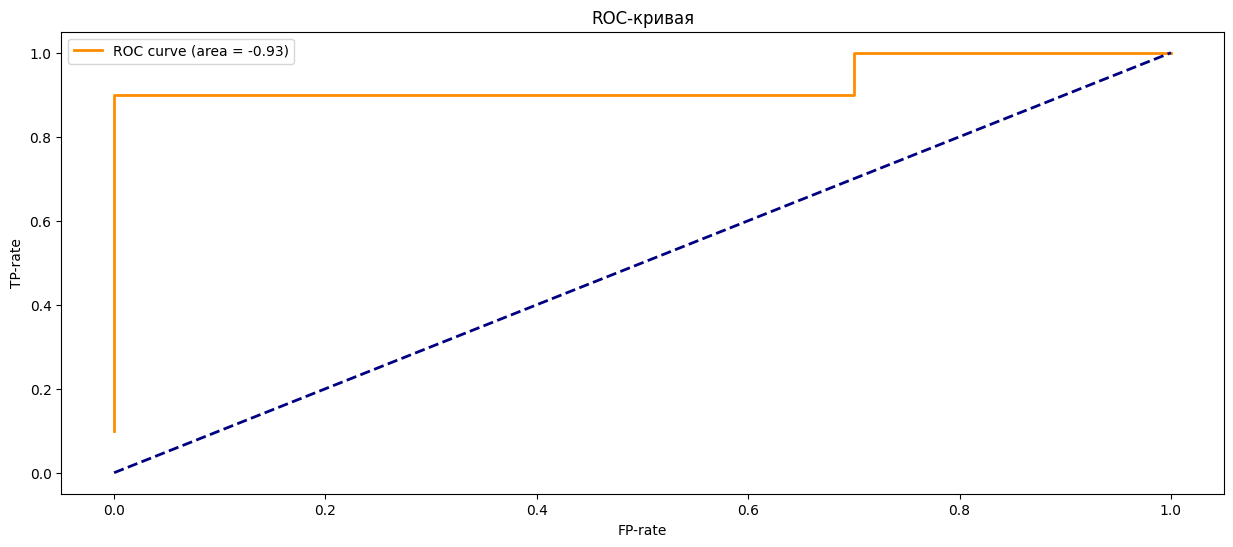

In [37]:
plt.figure(figsize=(15, 6))
plt.title('ROC-кривая')

lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('FP-rate')
plt.ylabel('TP-rate')
plt.legend()
plt.show()